In [1]:
#hide
#default_exp tools.metric_visualization
from nbdev.showdoc import *
from dsblocks.utils.nbdev_utils import nbdev_setup, TestRunner

nbdev_setup ()
tst = TestRunner (targets=['dummy'])

# Metric visualization

> Visualize metrics collected from experiments.

In [2]:
#export
import warnings
warnings.filterwarnings('ignore')

import argparse
import sys
sys.path.append('.')
sys.path.append('src')
import pandas as pd
import pickle

import hpsearch.visualization.experiment_visualization as ev
from hpsearch.config.hpconfig import get_experiment_manager, get_path_experiments
import hpsearch.config.hp_defaults as dflt

In [3]:
#for tests
import pytest
from hpsearch.examples.dummy_experiment_manager import generate_data

## include best and last experiment

In [4]:
#export
def include_best_and_last_experiment (metrics, experiments=[-1, -2], run_number=0, 
                                      op='max', manager_path=dflt.manager_path,):
    path_experiments = get_path_experiments (manager_path=manager_path)
    for i in range(len(experiments)):
        if experiments[i] == -1:
            experiment_number = pickle.load(open(path_experiments/'current_experiment_number.pkl','rb'))
            experiments[i] = experiment_number

        if experiments[i] == -2:
            first_metric = metrics[0]
            if len(metrics)>1:
                print (f'we use the first metric {first_metric} in given list {metrics} for obtaining the best experiment')
            df = pd.read_csv(path_experiments/'experiments_data.csv',index_col=0)
            score_column = f'{run_number}_{first_metric}'
            if score_column in df.columns:
                if op=='max':
                    experiments[i] = df[score_column].idxmax()
                else:
                    experiments[i] = df[score_column].idxmin()
            else:
                del experiments[i]
                
    return experiments

In [5]:
#export
def metric_visualization (experiments=[-1,-2], run_number=0, folder=None, metric=None, op = None,
                          parameters=None, name_file='model_history.pk', visualization_options = {},
                          backend='plotly', manager_path=dflt.manager_path, **kwargs):
    
    if folder is not None or metric is not None or op is not None:
        em = get_experiment_manager (manager_path=manager_path)
        if folder is not None: em.set_path_experiments (folder=folder)
        if metric is not None: em.key_score = metric
        if op is not None: em.op = op
    folder = em.folder
    metric = em.key_score
    op = em.op
    
    # metrics
    if type(metric) is str:
        metrics = [metric]
    else:
        metrics = metric
        
    experiments = include_best_and_last_experiment (metrics, experiments=experiments, 
                                                    run_number=run_number, op=op,
                                                    manager_path=manager_path)
    
    visualization_options = visualization_options.copy()
    visualization_options.update(kwargs)
    if 'visualization' in visualization_options.keys():
        visualization = visualization_options.pop('visualization')
    else:
        visualization = 'history'
    
    ev.visualize_experiments(visualization=visualization, 
                             experiments=experiments, run_number=run_number, 
                             metrics=metrics, parameters=parameters, name_file=name_file, 
                             **visualization_options, backend=backend)

## metric visualization

### Basic usage

In [6]:
#export tests.tools.test_metric_visualization
def test_metric_visualization ():
    em = generate_data ('metric_visualization')
    
    print ('default visualization')
    metric_visualization()
    
    print ('visualizing test_accuracy, and experiments -2 and 0')
    metric_visualization(experiments=[-2, 0], metric='test_accuracy', manager_path=em.manager_path)
    
    print ('using matplotlib as backend')
    metric_visualization(experiments=[3, 7], metric='test_accuracy', backend='matplotlib', 
                         manager_path=em.manager_path)
    
    em.remove_previous_experiments (parent=True)

running test_metric_visualization
default visualization


,epochs,validation_accuracy
8,30.0,1.0
5,15.0,1.0


visualizing test_accuracy, and experiments -2 and 0


,epochs,offset,test_accuracy
5,15.0,0.6,1.000000
0,5.0,0.1,0.412303


using matplotlib as backend


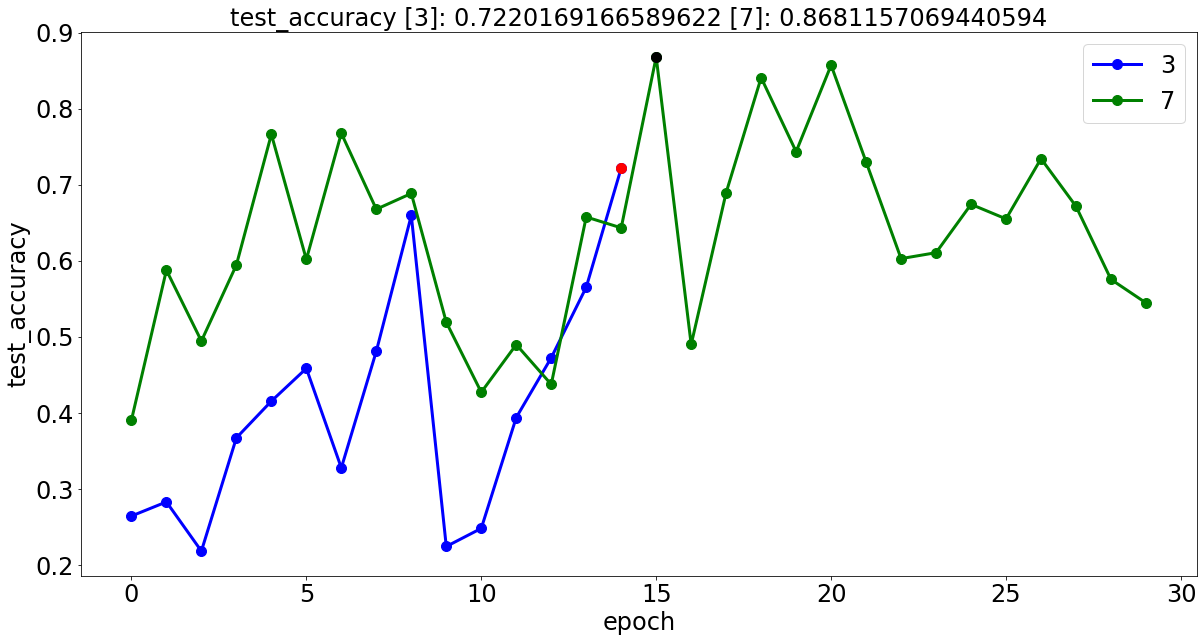

,epochs,offset,test_accuracy
3,15.0,0.1,0.722017
7,30.0,0.3,0.868116


In [7]:
tst.run (test_metric_visualization, tag='dummy')

### Using more than one visualization routine

In [8]:
#export tests.tools.test_metric_visualization
def test_several_visualizations ():
    em = generate_data ('several_visualizations')
    
    metric_visualization(experiments=[3, 7], metric='test_accuracy', backend='matplotlib', 
                         visualization_options={'visualization': ['history', 'metric_correlation', 
                                                                  'custom'],
                                                'metric_1': 'validation_accuracy',
                                                'metric_2': 'test_accuracy'},
                         manager_path=em.manager_path)
    em.remove_previous_experiments (parent=True)

running test_several_visualizations


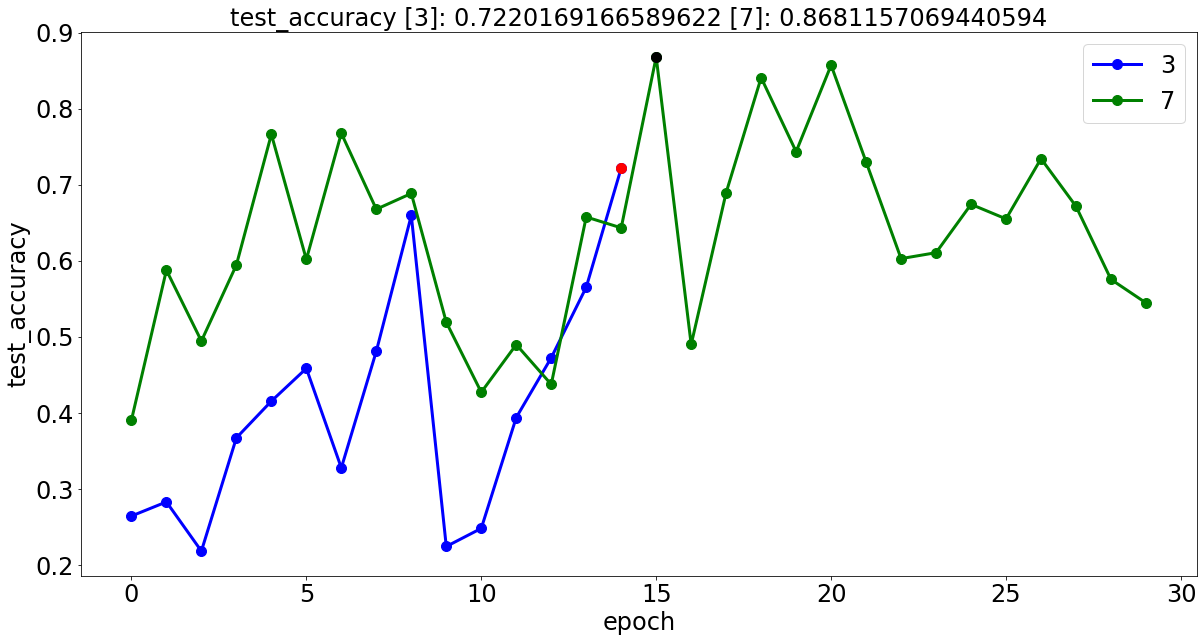

,epochs,offset,test_accuracy
3,15.0,0.1,0.722017
7,30.0,0.3,0.868116


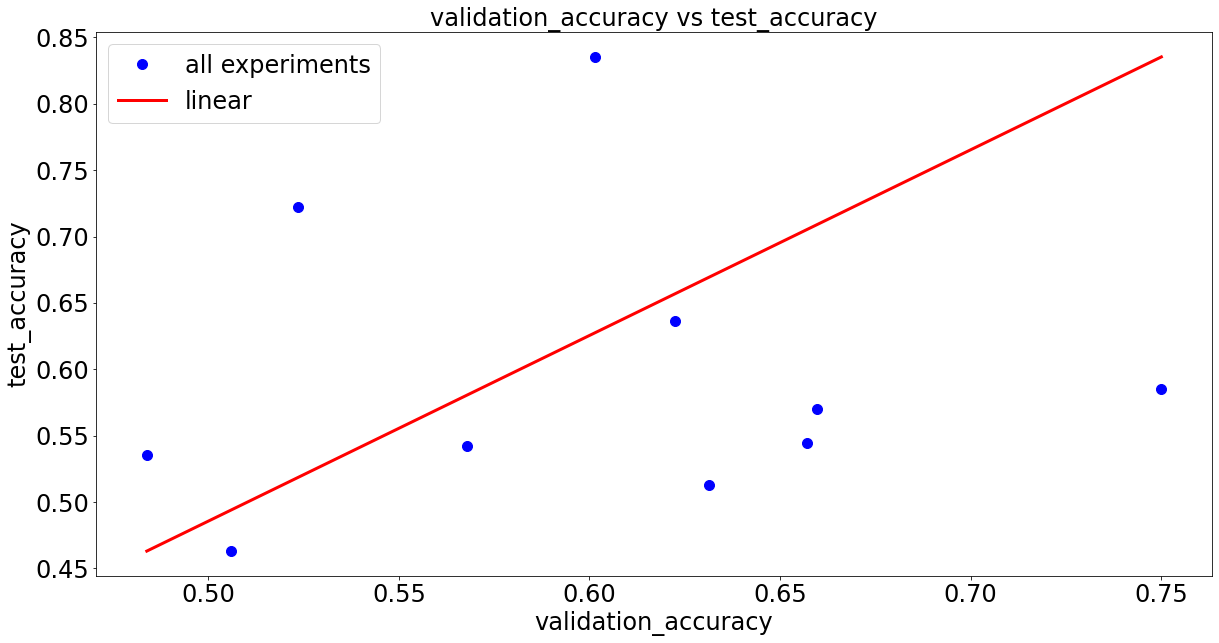

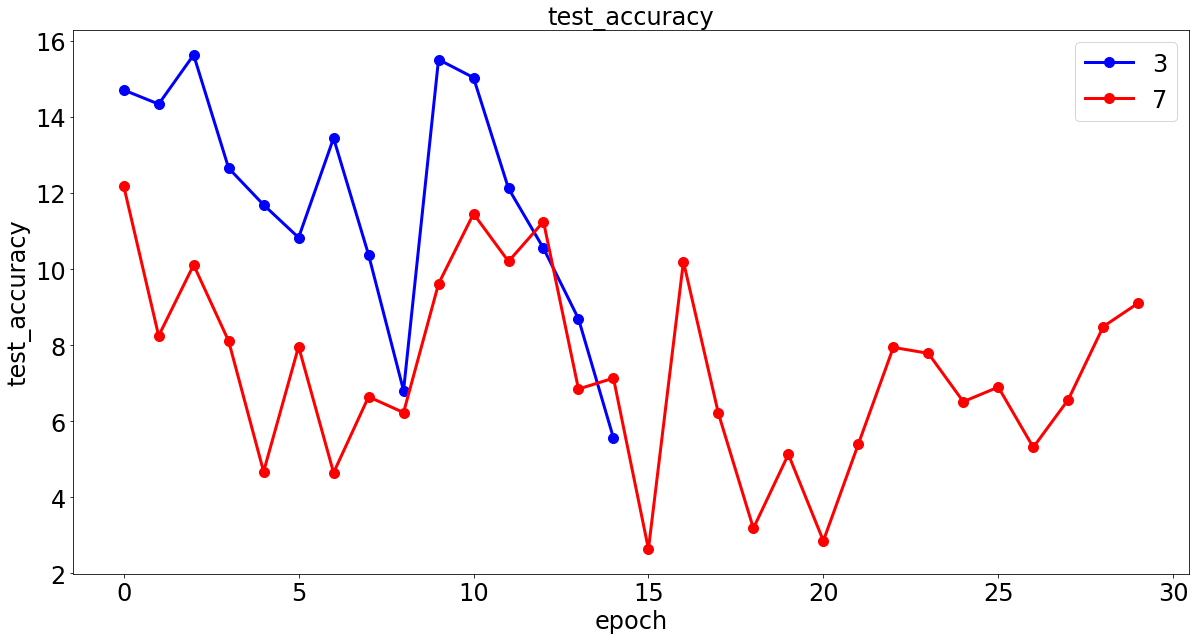

In [9]:
tst.run (test_several_visualizations, tag='dummy')

### Visualize more than one metric

In [10]:
#export tests.tools.test_metric_visualization
def test_several_metrics ():
    em = generate_data ('several_metrics')
    
    metric_visualization (experiments=[-1,-2], metric=['test_accuracy', 'validation_accuracy'], 
                          backend='matplotlib', manager_path=em.manager_path)
    
    em.remove_previous_experiments (parent=True)

running test_several_metrics
we use the first metric test_accuracy in given list ['test_accuracy', 'validation_accuracy'] for obtaining the best experiment


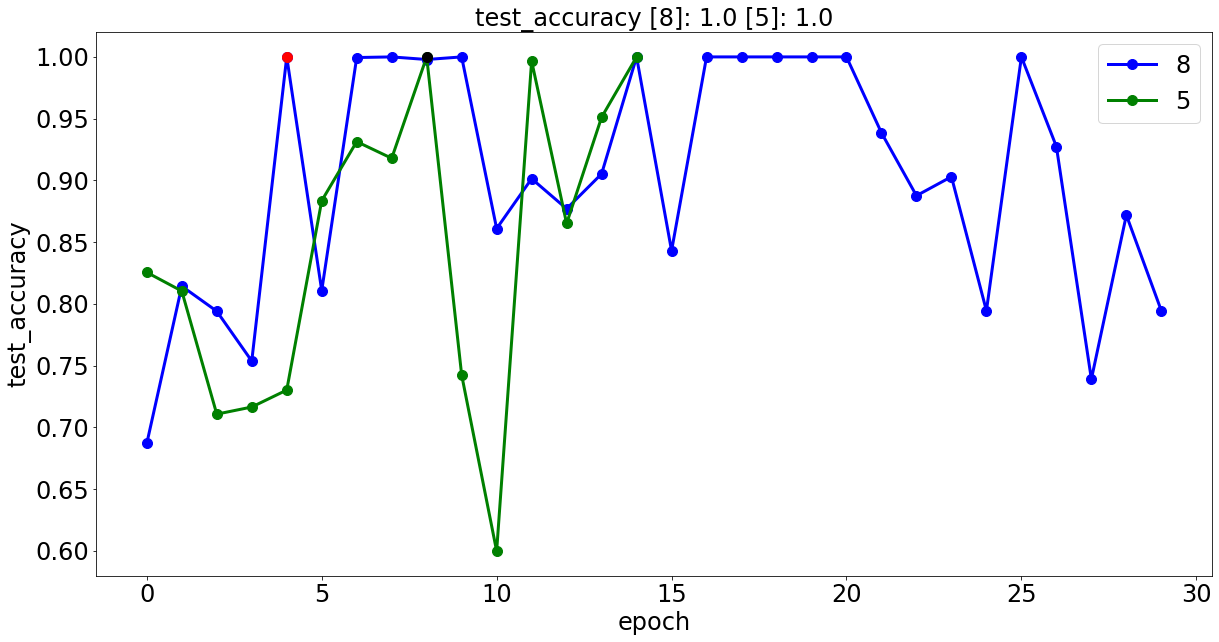

,epochs,test_accuracy
8,30.0,1.0
5,15.0,1.0


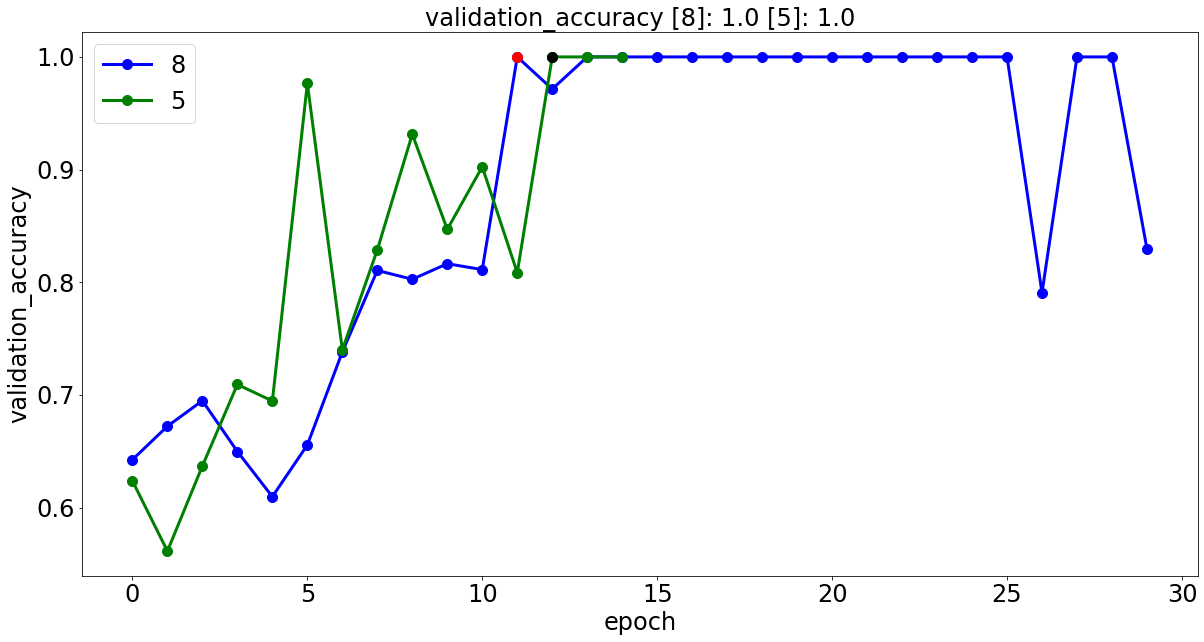

,epochs,test_accuracy,validation_accuracy
8,30.0,1.0,1.0
5,15.0,1.0,1.0


In [11]:
tst.run (test_several_metrics, tag='dummy')

### visualize more than one metric in same plot

In [12]:
#export tests.tools.test_metric_visualization
def test_several_metrics_same_plot ():
    em = generate_data ('several_metrics_same_plot')
    
    metric_visualization (experiments=[-1], metric=['validation_accuracy'], 
                          metrics_second=['test_accuracy'],
                          backend='matplotlib', manager_path=em.manager_path)
    
    em.remove_previous_experiments (parent=True)

running test_several_metrics_same_plot


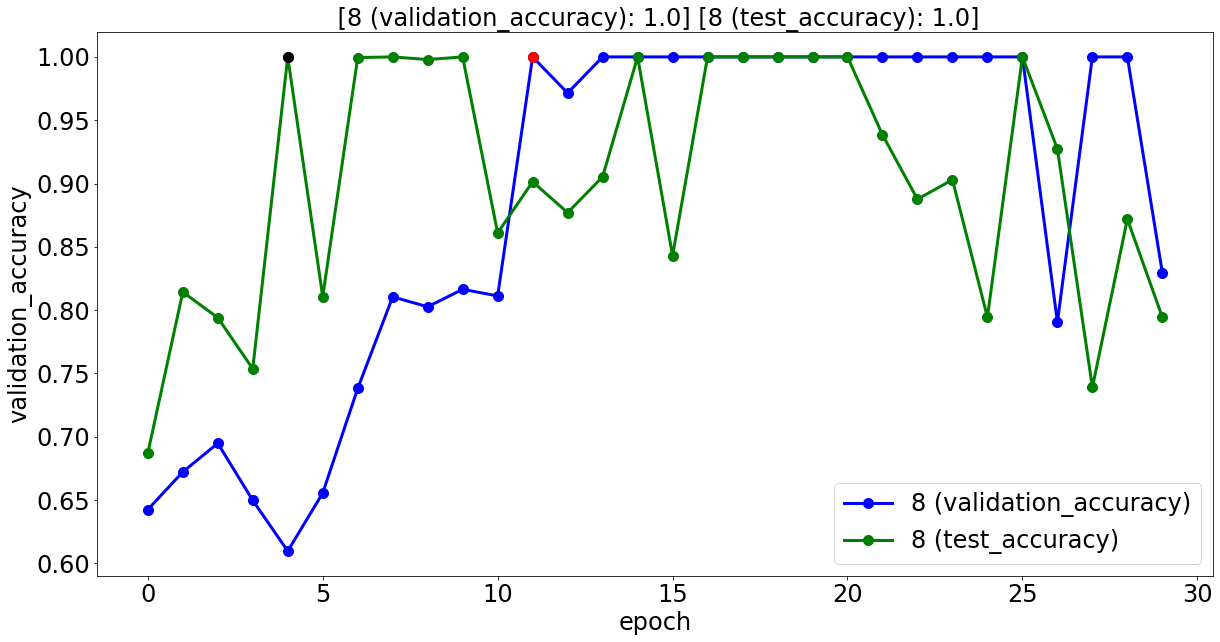

,validation_accuracy,test_accuracy
8,1.0,1.0


In [13]:
tst.run (test_several_metrics_same_plot, tag='dummy')

## parse_args

In [14]:
#export
def parse_args(args):
    parser = argparse.ArgumentParser(description='show metrics about experiments') 
    # Datasets
    parser.add_argument('-e', nargs='+', default=[-1, -2], type=int,
                        help="experiments")
    parser.add_argument('-m', '--metric', nargs='+', type=str, default=None, help="metrics")
    parser.add_argument('--folder', type=str, default=None)
    parser.add_argument('-l','--labels',nargs='+', default=None, type=str)
    parser.add_argument('--run', default=0, type=int)
    parser.add_argument('--op', default=None, type=str)
    parser.add_argument('-b', '--backend', default='visdom', type=str)
    parser.add_argument('-f', '--file', default='model_history.pk', type=str)
    parser.add_argument('-v', '--visualization', default='{}', type=str)
    parser.add_argument('-p', '--path', default=dflt.manager_path, type=str)

    pars = parser.parse_args(args)
    
    pars.visualization = eval(pars.visualization)
    
    return pars

def parse_arguments_and_visualize (args):
    
    pars = parse_args(args)

    metric_visualization (pars.e, run_number=pars.run, folder=pars.folder, metric=pars.metric, 
                          parameters=pars.labels, name_file=pars.file, backend=pars.backend, 
                          visualization_options=pars.visualization, manager_path=pars.path)
    
def main():

    parse_arguments_and_visualize (sys.argv[1:])

### Test the command line parser

In [52]:
#export tests.tools.test_metric_visualization
def test_parse_arguments_and_visualize ():
    em = generate_data ('parse_arguments_and_visualize')

    visualization_options = "{'visualization': ['history', 'metric_correlation', 'custom'], " \
                         "'metric_1': 'validation_accuracy', 'metric_2': 'test_accuracy'}"

    command = '-e 3 7 -m test_accuracy -b matplotlib -v '.split ()
    command += [f'{visualization_options}']
    command += f'-p {em.manager_path}'.split()

    parse_arguments_and_visualize (command)
    
    em.remove_previous_experiments (parent=True)

running test_parse_arguments_and_visualize


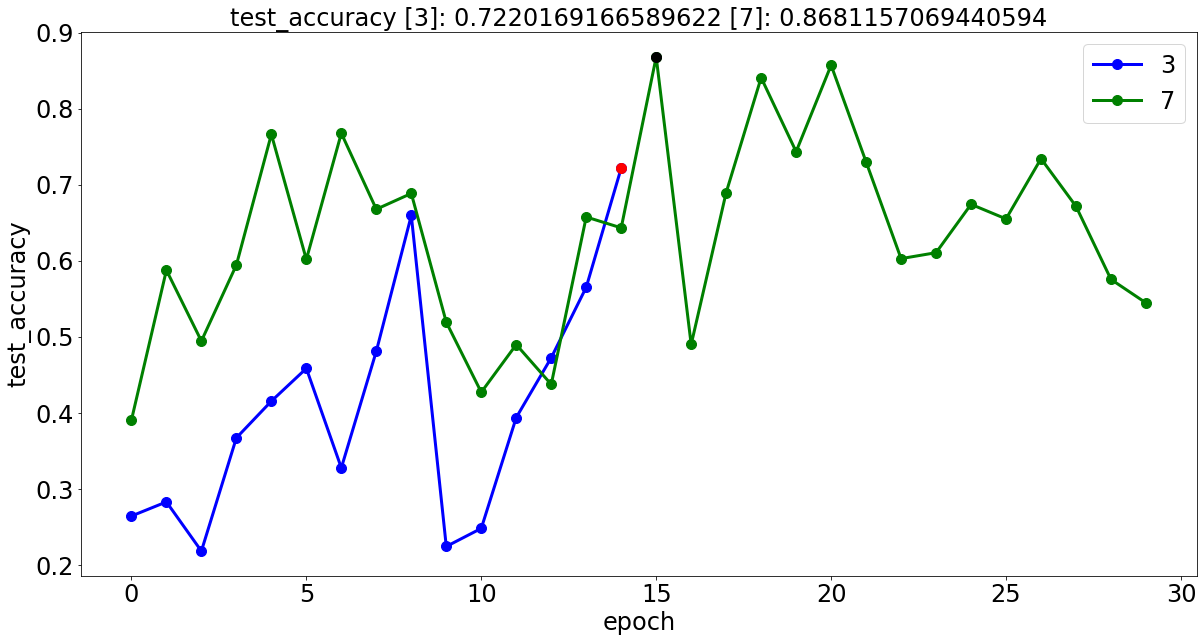

,epochs,offset,test_accuracy
3,15.0,0.1,0.722017
7,30.0,0.3,0.868116


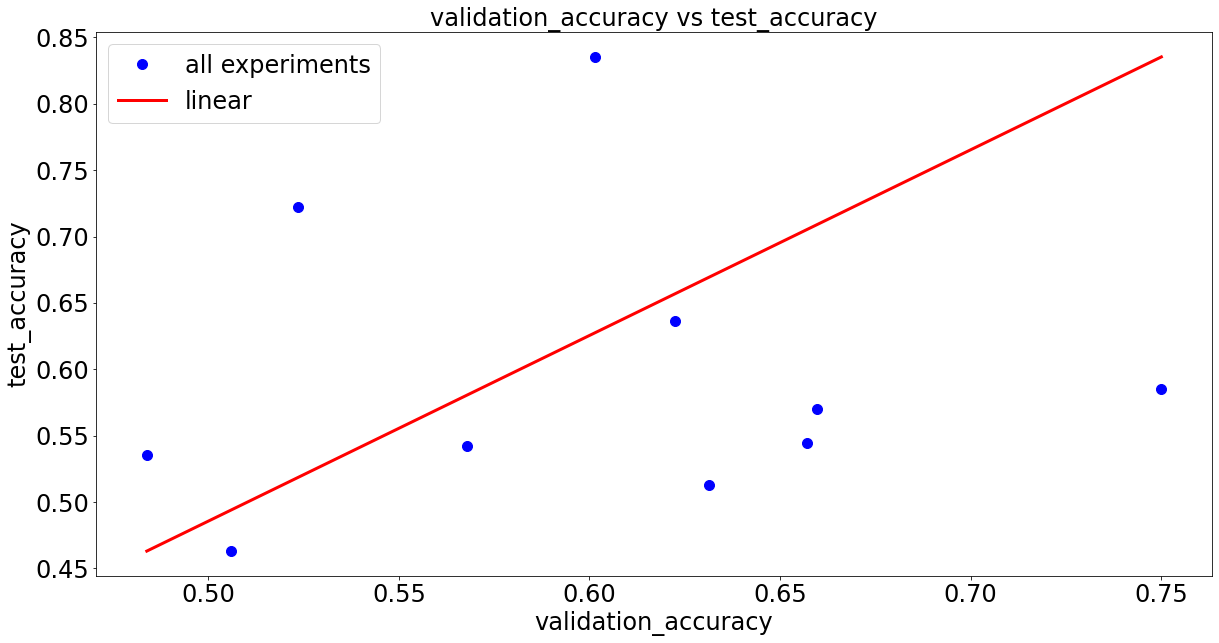

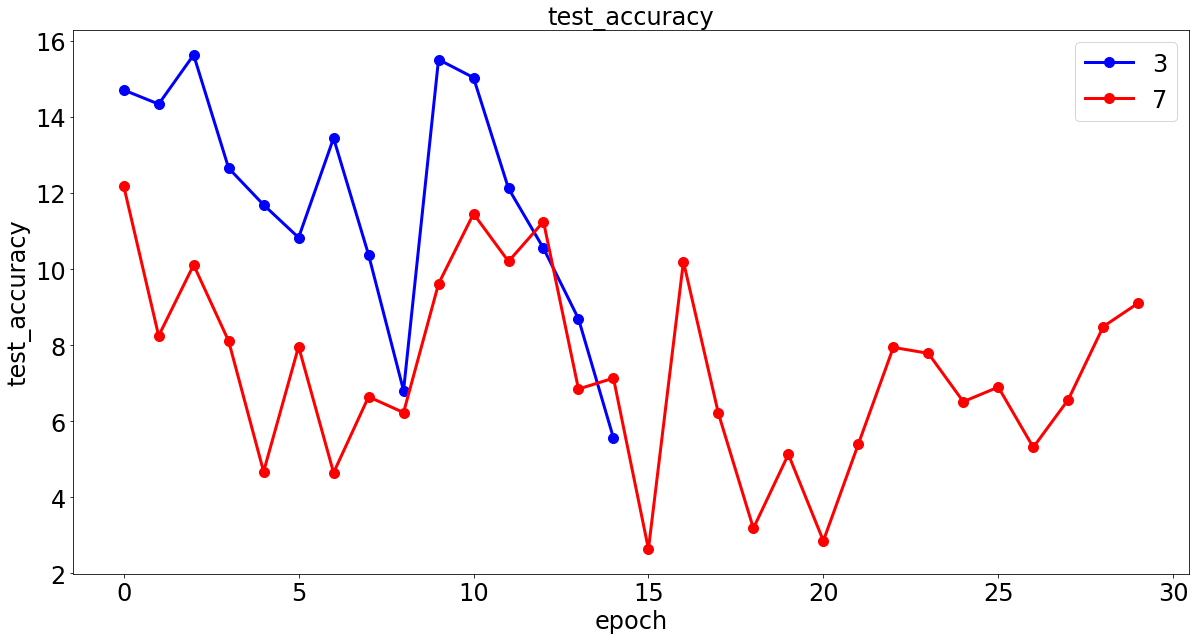

In [53]:
tst.run (test_parse_arguments_and_visualize, tag='dummy')